In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=cba87347-13bc-411f-ae10-cd33a65acd1b
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 23.2MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

import numpy as np

def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result

def create_path_as_list(pairs_list):
    wanted_length = len(pairs_list)
    path = ''
    current_pair = next(pair for pair in pairs_list if pair[0] == 0)
    path += str(current_pair[0])

    next_start = current_pair[1]

    pairs_list.remove(current_pair)

    while len(path) < wanted_length:
        path += str(next_start)
        current_pair = next(pair for pair in pairs_list if pair[0] == next_start)
        pairs_list.remove(current_pair)
        next_start = current_pair[1]

    return path

def find_paths_vrb(edges, k):
    def find_path_vrb(current_path):
        if len(paths) >= k:
            return

        last_node = current_path[-1]

        if last_node == 0 and len(current_path) > 1:
            paths.append(current_path)
            return

        for edge in edges:
            if edge[0] == last_node:
                find_path_vrb(current_path + [edge[1]])

    paths = []
    find_path_vrb([0])

    return paths

def repetitions(list1, list2):
  common_elements = set(list1) & set(list2)
  return (2*len(common_elements))/len(list1+list2)

def equal_paths(list1, list2):
  are_equal = sorted(list1) == sorted(list2)
  if are_equal:
    return 1
  else:
    return 0

In [ ]:
df = pd.read_csv(os.path.join(output_dir, "X"))

In [ ]:
real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
cost = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Road Distance to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name].replace(",", "").replace(" km", "")
            cost[i][j] = float(distance)

print("Cost matrix:")
for row in cost:
    print(f"{row},")

Cost matrix:
[0, 605.0, 407.0, 682.0, 281.0, 464.0, 151.0, 452.0, 613.0, 230.0, 759.0, 703.0, 641.0, 321.0, 904.0, 618.0],
[605.0, 0, 342.0, 977.0, 835.0, 517.0, 705.0, 568.0, 693.0, 844.0, 1053.0, 998.0, 79.4, 934.0, 1254.0, 1172.0],
[407.0, 342.0, 0, 661.0, 400.0, 201.0, 324.0, 253.0, 378.0, 640.0, 738.0, 683.0, 399.0, 730.0, 939.0, 736.0],
[682.0, 977.0, 661.0, 0, 434.0, 586.0, 558.0, 471.0, 458.0, 675.0, 68.7, 32.9, 1033.0, 636.0, 284.0, 226.0],
[281.0, 835.0, 400.0, 434.0, 0, 414.0, 158.0, 267.0, 426.0, 357.0, 514.0, 459.0, 771.0, 416.0, 659.0, 388.0],
[464.0, 517.0, 201.0, 586.0, 414.0, 0, 341.0, 91.1, 180.0, 695.0, 667.0, 607.0, 574.0, 786.0, 891.0, 659.0],
[151.0, 705.0, 324.0, 558.0, 158.0, 341.0, 0, 328.0, 490.0, 382.0, 637.0, 582.0, 740.0, 472.0, 782.0, 496.0],
[452.0, 568.0, 253.0, 471.0, 267.0, 91.1, 328.0, 0, 169.0, 681.0, 548.0, 493.0, 624.0, 771.0, 749.0, 546.0],
[613.0, 693.0, 378.0, 458.0, 426.0, 180.0, 490.0, 169.0, 0, 849.0, 522.0, 481.0, 755.0, 944.0, 733.0, 639.0]

VRPSPD

In [ ]:
n = 20
m = 4
Q = 100


d = generate_list(n + 1, 0.6 * Q * m)
p = generate_list(n + 1, 0.6 * Q * m)

vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

for j in range(1, n+1):
    vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

for k in range(m):
  for j in range(n+1):
    vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

for k in range(m):
  vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

for j in range(1, n+1):
  vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

for j in range(1, n+1):
  vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

for i in range(n+1):
  for j in range(n+1):
    if i != j:
      vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
for i in range(1,n+1):
   vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
   vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

vrpsdp.solve()

print("Status:", pulp.LpStatus[vrpsdp.status])

Status: Optimal


In [ ]:
if m == 2:
  nof_stops = [0,0]
  cost_function_for_vechicle = [0,0]
else:
  nof_stops = [0,0,0,0]
  cost_function_for_vechicle = [0,0,0,0]

strings_nof_stops = []
strings_cost_function_for_vechicle = []

for klucz in [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)]:
  if  x[klucz].varValue == 1:
    print(f'klucz {klucz} wartosc: {x[klucz].varValue}')
    nof_stops[klucz[2]] += 1
    cost_function_for_vechicle[klucz[2]] += cost[klucz[0]][klucz[1]]

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

print(sum(nof_stops))
print(sum(cost_function_for_vechicle))

for i in nof_stops:
  strings_nof_stops.append(f"v{nof_stops.index(i) + 1}:{i}")
print(', '.join(strings_nof_stops))

for i in cost_function_for_vechicle:
  strings_cost_function_for_vechicle.append(f"v{cost_function_for_vechicle.index(i) + 1}:{i}")
print(', '.join(strings_cost_function_for_vechicle))

klucz (0, 11, 2) wartosc: 1.0
klucz (0, 12, 1) wartosc: 1.0
klucz (0, 15, 0) wartosc: 1.0
klucz (0, 20, 3) wartosc: 1.0
klucz (1, 4, 1) wartosc: 1.0
klucz (2, 13, 0) wartosc: 1.0
klucz (3, 7, 0) wartosc: 1.0
klucz (4, 5, 1) wartosc: 1.0
klucz (5, 17, 1) wartosc: 1.0
klucz (6, 2, 0) wartosc: 1.0
klucz (7, 18, 0) wartosc: 1.0
klucz (8, 0, 0) wartosc: 1.0
klucz (9, 16, 2) wartosc: 1.0
klucz (10, 0, 2) wartosc: 1.0
klucz (11, 19, 2) wartosc: 1.0
klucz (12, 1, 1) wartosc: 1.0
klucz (13, 3, 0) wartosc: 1.0
klucz (14, 0, 1) wartosc: 1.0
klucz (15, 6, 0) wartosc: 1.0
klucz (16, 10, 2) wartosc: 1.0
klucz (17, 14, 1) wartosc: 1.0
klucz (18, 8, 0) wartosc: 1.0
klucz (19, 9, 2) wartosc: 1.0
klucz (20, 0, 3) wartosc: 1.0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
24
6626
v1:9, v2:7, v3:6, v4:2
v1:1759, v2:2989, v3:1578, v4:300


VRPB

In [ ]:
number_of_clients = 20

L_B = list(range(1, number_of_clients + 1))
SOURCE = 0
midpoint = number_of_clients - 4
L = L_B[:midpoint]
L0 = L[:]
L0.insert(0,0)
B = L_B[midpoint:]
B0 = B[:]
B0.insert(0,0)
Cu = L_B
V = list(range(0, number_of_clients + 1))
print(B)

Q = 100
K = 2

D = generate_list(len(L) + 1, 2 * Q * K)
D.append(1)
D.append(1)
D.append(1)
D.append(1)

print(sum(D))

Kl = K
Kb = K

[17, 18, 19, 20]
403.99999999999994


In [ ]:
from posixpath import join

s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

cost_function = pulp.lpSum(s[i,j] * cost[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
model += cost_function

model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

for j in L:
  model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

for j in L:
  model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

for j in L:
  model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

for j in L:
  for i in L0:
    if i != j:
      model += l[(i,j)] <= Q * s[(i,j)]

fraaction7 = pulp.lpSum(D[j] for j in L)/Q
model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

for j in B:
  model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

for j in B:
  model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

for j in B:
  model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

for j in B0:
  for i in B:
    if i != j:
      model += l[i,j] <= Q * s[i,j]

fraaction13 = pulp.lpSum(D[j] for j in B)/Q
model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

for i in V:
  for j in V:
    if i != j:
      model += s[i,j] + s[j,i] <= 1


model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

model += pulp.lpSum(s[0, j] for j in B) == 0

model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

In [ ]:
model.solve()
print("Total Cost:", pulp.value(model.objective)/100)

Total Cost: 75.85


In [ ]:
for i in V:
  for j in V:
    if i != j:
      if  s[i,j].varValue == 1:
        print(f'klucz {i,j} wartosc{s[i,j].varValue}')
print("#############################")
for i in L:
   for j in B0:
     if i != j:
      if  e[i,j].varValue == 1:
        print(f'klucz {i,j} wartosc{e[i,j].varValue}')

klucz (0, 6) wartosc1.0
klucz (0, 8) wartosc1.0
klucz (0, 10) wartosc1.0
klucz (0, 11) wartosc1.0
klucz (0, 15) wartosc1.0
klucz (1, 12) wartosc1.0
klucz (2, 16) wartosc1.0
klucz (3, 13) wartosc1.0
klucz (4, 5) wartosc1.0
klucz (5, 1) wartosc1.0
klucz (6, 2) wartosc1.0
klucz (8, 14) wartosc1.0
klucz (11, 4) wartosc1.0
klucz (13, 7) wartosc1.0
klucz (15, 3) wartosc1.0
klucz (16, 9) wartosc1.0
klucz (17, 0) wartosc1.0
klucz (18, 0) wartosc1.0
klucz (19, 0) wartosc1.0
klucz (20, 0) wartosc1.0
#############################
klucz (7, 18) wartosc1.0
klucz (9, 19) wartosc1.0
klucz (10, 20) wartosc1.0
klucz (12, 0) wartosc1.0
klucz (14, 17) wartosc1.0


Check percentege of load


In [ ]:
nof_runs = 20
data_generation_percentege =[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
output_1 = []

In [ ]:
output_1 = []
for percent in data_generation_percentege:
    output.append([])
    start_time = time.time()
    for run_number in range(nof_runs):
      n = 10
      m = 2
      Q = 100

      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
        vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])

    end_time = time.time()
    elapsed_time = end_time - start_time

    TIME.append(elapsed_time)

    print(f"Elapsed time: {elapsed_time} seconds")

Total Cost for 0.0% and run 0:, 29.454
Total Cost for 0.0% and run 1:, 29.454
Total Cost for 0.0% and run 2:, 29.454
Total Cost for 0.0% and run 3:, 29.454
Total Cost for 0.0% and run 4:, 29.454
Total Cost for 0.0% and run 5:, 29.454
Total Cost for 0.0% and run 6:, 29.454
Total Cost for 0.0% and run 7:, 29.454
Total Cost for 0.0% and run 8:, 29.454
Total Cost for 0.0% and run 9:, 29.454
Total Cost for 0.0% and run 10:, 29.454
Total Cost for 0.0% and run 11:, 29.454
Total Cost for 0.0% and run 12:, 29.454
Total Cost for 0.0% and run 13:, 29.454
Total Cost for 0.0% and run 14:, 29.454
Total Cost for 0.0% and run 15:, 29.454
Total Cost for 0.0% and run 16:, 29.454
Total Cost for 0.0% and run 17:, 29.454
Total Cost for 0.0% and run 18:, 29.454
Total Cost for 0.0% and run 19:, 29.454
Total Cost for 0.05% and run 0:, 41.200999999999965
Total Cost for 0.05% and run 1:, 41.201
Total Cost for 0.05% and run 2:, 41.201
Total Cost for 0.05% and run 3:, 41.201
Total Cost for 0.05% and run 4:, 41.20

In [ ]:
output_1 = [[41.200999999999965, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.20100000000446, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201000000000185, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.201, 41.201000000000015, 41.201, 41.201, 41.201, 41.201, 41.20100000000002, 41.201, 41.201000000000604, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.20099999999996, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.20100000000021, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.200999999999986, 41.201, 41.2009999999994, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.201, 41.200999999999986, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201000000000015, 41.20099999999995, 41.20100000000002, 41.201, 41.201], [41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201, 41.20100000000013, 41.201, 41.201, 41.201, 41.20099999999999, 41.201, 41.201, 41.201, 41.201, 41.201, 41.201], [41.201, 41.201, 41.200999999999986, 41.20100000000008, 41.201, 41.201, 41.201, 41.201, 41.20099928260251, 41.201, 41.201000000000015, 41.441, 41.201, 41.201, 41.20099999999971, 41.201, 41.201, 41.201, 41.20100000000037, 41.201], [43.23100000000002, 43.230999999999995, 43.231, 41.441, 41.201, 43.231, 43.230999999999895, 43.231, 41.201, 41.20100000000044, 43.231, 41.201, 41.44099999999999, 41.201000000000015, 41.441, 41.200999999999965, 41.441, 41.201, 41.201, 41.201], [43.631, 43.231, 43.68, 43.68, 43.631, 43.631, 43.631, 43.341, 43.63100000000005, 43.631, 43.231000000000165, 43.631, 43.630999999999915, 43.63100000000002, 43.631, 43.231, 43.631, 43.631, 43.68, 43.68], [43.68, 43.68, 43.68, 43.631, 43.68, 43.68, 43.68000000000016, 43.68, 43.68, 43.680000000000035, 43.68, 43.68, 43.68, 43.68, 43.231, 43.68, 43.67999999999999, 43.68, 43.63099999999999, 43.631], [43.63099999999976, 43.68, 43.68000000000002, 44.28, 43.68, 43.68, 43.68, 43.63099999999986, 43.68000000000002, 43.68, 43.68, 44.28, 43.68, 43.67999949234438, 43.68, 43.231, 43.679999999881694, 43.68, 43.68, 43.68], [43.68, 43.68, 43.68, 43.68, 43.68, 43.68, 43.68, 43.67999999999989, 44.27999999999913, 43.68, 43.67999999999994, 43.68, 43.68, 43.68000000000001, 43.68, 43.68, 43.68, 43.68, 43.68, 43.68], [43.68, 43.68, 44.27999999999998, 43.69, 43.68000000000004, 43.68, 43.68, 43.68, 47.06, 47.93, 44.28, 43.68, 43.68, 43.68, 43.68000000000002, 44.28, 43.68, 43.68, 43.68, 43.67999999999998], [43.68, 45.670000000000044, 47.779999999999944, 44.32, 43.68, 44.28, 43.68, 44.28, 43.68, 43.68, 43.68, 43.68, 43.680000000000035, 48.07, 43.68, 43.71, 43.68, 44.28, 43.68, 44.28], [43.69, 44.3, 43.68, 48.24, 50.60099999999999, 44.96, 44.28, 45.711000000000006, 45.501000000000005, 48.990000000000016, 44.28, 43.68, 44.28, 47.03, 44.32, 44.29999999999992, 48.98999999999342, 48.20999999999998, 44.99, 48.20999999999436]]

In [ ]:
output_2 = []
for percent in data_generation_percentege:
    output_2.append([])
    for run_number in range(nof_runs):
      n = 15
      m = 3
      Q = 100

      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
        vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])


Total Cost for 0.0% and run 0:, 33.754
Total Cost for 0.0% and run 1:, 33.754
Total Cost for 0.0% and run 2:, 33.754
Total Cost for 0.0% and run 3:, 33.754
Total Cost for 0.0% and run 4:, 33.754
Total Cost for 0.0% and run 5:, 33.754
Total Cost for 0.0% and run 6:, 33.754
Total Cost for 0.0% and run 7:, 33.754
Total Cost for 0.0% and run 8:, 33.754
Total Cost for 0.0% and run 9:, 33.754
Total Cost for 0.0% and run 10:, 33.754
Total Cost for 0.0% and run 11:, 33.754
Total Cost for 0.0% and run 12:, 33.754
Total Cost for 0.0% and run 13:, 33.754
Total Cost for 0.0% and run 14:, 33.754
Total Cost for 0.0% and run 15:, 33.754
Total Cost for 0.0% and run 16:, 33.754
Total Cost for 0.0% and run 17:, 33.754
Total Cost for 0.0% and run 18:, 33.754
Total Cost for 0.0% and run 19:, 33.754
Total Cost for 0.05% and run 0:, 43.94099999999991
Total Cost for 0.05% and run 1:, 43.941
Total Cost for 0.05% and run 2:, 43.941
Total Cost for 0.05% and run 3:, 43.94100000000657
Total Cost for 0.05% and run

In [ ]:
# print(output_2)
output_2 = [[43.94099999999991, 43.941, 43.941, 43.94100000000657, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941000000019, 43.941, 43.941, 43.941], [43.9410000000027, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941000000000024, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941], [43.941, 43.941, 43.941, 43.941, 43.941, 43.94100000000346, 43.941, 43.941, 43.9410000000001, 43.941, 43.94099999999886, 43.941, 43.941, 43.941, 43.941, 43.941, 43.9410000000039, 43.941, 43.941, 43.941], [43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.94099999999999, 43.941, 43.941, 43.940999999999995, 43.941, 43.941, 43.94100000000012, 43.941, 43.941, 43.941000000000095, 43.94100000000016, 43.941000000000024], [43.94100000000052, 43.941, 43.941, 43.941, 43.94099999999997, 43.940999999999995, 43.94100000004478, 43.941, 43.941, 43.941000000004415, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941], [43.941, 43.941, 43.941, 43.941, 43.94099999999977, 43.941, 43.941, 43.941000000000095, 43.941, 43.94099999999996, 43.941, 43.941, 43.941, 43.94099999999385, 43.941, 43.941, 43.941, 43.941, 43.941, 43.941], [44.15099999999955, 43.941, 44.18100000000026, 43.94100000000051, 44.181000000000004, 43.941, 43.941000000000315, 43.941, 44.181000000000004, 44.18100000000517, 43.94100000000279, 43.94099999999208, 45.15200000000001, 44.391000000000005, 43.941, 44.181000000000004, 45.501000000000005, 44.181000000000004, 44.181000000000004, 43.94099999999984], [45.971000000000004, 45.971000000000004, 44.18100000000033, 45.970999999999904, 45.971000000000004, 45.971000000000004, 45.71100000000059, 45.971, 45.50099999999992, 45.1519999999992, 45.971, 46.42999999999931, 45.57099999999955, 45.501000000000005, 45.97099999997427, 44.181000000000004, 44.181000000000004, 45.970999999998604, 45.971000000000004, 45.97100000000003], [46.43, 46.43, 46.43000000000035, 46.429999999999644, 46.43, 46.43, 46.43, 45.971000000000004, 46.43, 46.43, 46.43, 46.42999999999978, 46.43, 46.42999999999991, 45.971, 46.43, 46.43000000000062, 46.43, 46.43, 46.43], [46.42999955086255, 46.43, 46.43, 46.46000000000021, 46.43, 46.43, 46.43, 46.43, 46.43, 46.43, 47.02, 46.42999999999999, 46.42999999999994, 46.43, 46.43, 46.43, 46.43000000000012, 46.43, 46.43, 46.43], [46.43, 48.269999999998205, 47.02, 46.43, 46.46, 47.02, 46.43, 47.02, 46.43, 47.02000000000001, 46.43, 46.43000000000419, 47.02, 46.43, 46.43, 46.43000000000025, 46.46, 47.02, 46.43, 47.98], [47.06, 47.02000000000001, 48.57999999999565, 46.43, 47.02, 47.02, 46.43, 47.98000000000118, 47.02, 47.02, 47.02, 46.43, 47.989999999999924, 46.46, 47.020000000000024, 47.02, 49.03000000000813, 46.43, 47.02, 49.65000000000011], [46.43000000000009, 49.64, 49.72000000000135, 47.02, 47.98, 48.59999999999998, 49.21, 49.24000000000128, 46.430000000002586, 48.24100000000001, 48.939999999999955, 48.97000000000002, 47.98, 46.43, 47.02, 49.03, 47.06000000000002, 50.85099999999999, 48.94000000000014, 49.34000000000018], [50.98, 50.449999999999726, 49.64, 51.02, 50.98, 55.35999999999938, 51.69, 50.97999999999979, 50.46, 48.94, 52.37, 50.74, 49.760999999999804, 48.051, 49.03000000000006, 53.95400000000798, 50.98000000000001, 49.69000000019405, 52.060000000000045, 50.361000000000004], [55.37, 50.98, 54.47999991880216, 51.70000000000011, 57.605, 52.43, 50.97999999999991, 52.43, 50.97999999999983, 52.43, 52.77, 53.07, 49.17, 49.64000000000004, 50.98, 48.98, 50.38, 52.94, 55.51000000000003, 53.641000000000005], [54.471, 53.76100000000017, 55.530000000002495, 54.14, 53.59100000000002, 54.63, 53.65099999999707, 51.7, 53.16099999999262, 54.14000000000009, 56.522, 55.27, 53.51000000000003, 51.73999999999943, 56.69200000000001, 57.68500000000092, 56.74100000000001, 54.04000000000029, 54.870000000002264, 51.990000000008905], [58.15000000000015, 57.451, 56.03000000000003, 55.68000000000004, 58.94999999999999, 52.43000000000007, 56.66, 55.74999999999987, 52.94, 56.43000000000001, 55.38000000000024, 56.24, 58.12999999999999, 56.12999999999995, 57.04000000000916, 51.78, 51.78, 55.29, 57.680999999989126, 56.34099999999985], [55.29, 58.139999999999894, 60.64400000000004, 62.99099999999999, 56.580999999999996, 54.87, 61.36, 61.721, 72.15, 56.62, 59.21, 58.62, 59.21, 57.68099999999998, 62.291, 58.334, 63.791000000000004, 57.52, 56.279999999999994, 56.754000000000005]]

In [ ]:
output_3 = []
for percent in [0.75, 0.8, 0.85, 0.9]:
    output_3.append([])
    for run_number in range(nof_runs):
      n = 15
      m = 4
      Q = 100

      d = generate_list(n + 1, percent * Q * m)
      p = generate_list(n + 1, percent * Q * m)

      vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

      x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(n+1) for j in range(n+1) for k in range(m)], cat='Binary')
      y = pulp.LpVariable.dicts("y", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')
      z = pulp.LpVariable.dicts("z", [(i, j) for i in range(n+1) for j in range(n+1)], lowBound=0, cat='Continuous')

      vrpsdp += pulp.lpSum(cost[i][j] * x[i, j, k] for k in range(m) for i in range(n+1) for j in range(n+1) if i != j)

      for j in range(1, n+1):
          vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(n+1) if i != j) == 1

      for k in range(m):
        for j in range(n+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for i in range(n+1)) - pulp.lpSum(x[j,i,k] for i in range(n+1)) == 0

      for k in range(m):
        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1)) == 1

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(y[j,i] for i in range(n+1)) - pulp.lpSum(y[i,j] for i in range(n+1)) == p[j]

      for j in range(1, n+1):
        vrpsdp += pulp.lpSum(z[i,j] for i in range(n+1)) - pulp.lpSum(z[j,i] for i in range(n+1)) == d[j]

      for i in range(n+1):
        for j in range(n+1):
          if i != j:
            vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, n+1) for k in range(m)) == m
      for i in range(1,n+1):
        vrpsdp += pulp.lpSum(x[i,j,k] for j in range(n+1) for k in range(m) if i != j) == 1
        vrpsdp += pulp.lpSum(x[j,i,k] for j in range(n+1) for k in range(m) if i != j) == 1

      vrpsdp.solve()

      if pulp.LpStatus[vrpsdp.status] == "Optimal":
        print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(vrpsdp.objective)/100}")

      output[data_generation_percentege.index(percent)].append(pulp.value(vrpsdp.objective)/100)

    print(output[-1])

Total Cost for 0.75% and run 0:, 68.32600000000001
Total Cost for 0.75% and run 1:, 65.11200000000001
Total Cost for 0.75% and run 2:, 63.593999999999994
Total Cost for 0.75% and run 3:, 58.149999999990854
Total Cost for 0.75% and run 4:, 64.74
Total Cost for 0.75% and run 5:, 63.54000000000073
Total Cost for 0.75% and run 6:, 57.551
Total Cost for 0.75% and run 7:, 61.632
Total Cost for 0.75% and run 8:, 61.99200000000106
Total Cost for 0.75% and run 9:, 58.10000000000072
Total Cost for 0.75% and run 10:, 61.620999999999995
Total Cost for 0.75% and run 11:, 56.72999999999999
Total Cost for 0.75% and run 12:, 62.104
Total Cost for 0.75% and run 13:, 58.1
Total Cost for 0.75% and run 14:, 58.10099999999813
Total Cost for 0.75% and run 15:, 61.37299999999999
Total Cost for 0.75% and run 16:, 64.362
Total Cost for 0.75% and run 17:, 61.31100000000001
Total Cost for 0.75% and run 18:, 75.46600000000001
Total Cost for 0.75% and run 19:, 59.11999999999921
Total Cost for 0.8% and run 0:, 62.0

KeyboardInterrupt: 

In [ ]:
# print(output_3)
output_3 = [[48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.2410000000107, 48.24100000000001, 48.24100000000953, 48.24100000000001, 48.24100000000001, 48.24099999999764, 48.24100000000306, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.241000000004206, 48.24100000006978], [48.24100000000001, 48.24100000000001, 48.24100000000001, 48.240999999995694, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.241000000038824, 48.24100000000001, 48.24100000001772, 48.24100000000001, 48.24100000000001, 48.240999999994266, 48.24100000000001, 48.24100000000001], [48.24100000000001, 48.24100000000466, 48.24100000000001, 48.2410000000024, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000004, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.240999999999964, 48.24100000000001, 48.241000000000014, 48.240999999985036], [48.24100000000015, 48.24100000000001, 48.24099999996712, 48.24100000000001, 48.24100000000001, 48.24100000001994, 48.24100000000001, 48.24100000000001, 48.240999999998515, 48.24100000000246, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24099987397037, 48.24100000000001, 48.24100000000001, 48.24099999999979, 48.24100000000001, 48.24100000000001, 48.24100000000001], [48.24100000000001, 48.241000000000014, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.240999999999325, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24099999999989, 48.240999999999396, 48.24099999999979, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001, 48.24100000000001], [48.4810000000001, 49.291000000000004, 48.4509999999999, 49.291000000000004, 48.24100000000001, 50.27100000000009, 49.29099999999997, 49.291000000000274, 48.24100000000001, 50.27099999999866, 49.290999999999194, 49.29099999084674, 48.24100000000001, 48.24100000000046, 50.270999999999994, 48.98100000000175, 50.271, 50.27099999998667, 50.262000000000306, 50.271], [49.291000000000075, 50.63099999999999, 50.271, 50.72999999999833, 50.271, 50.73, 50.73, 50.271, 50.27100000000034, 50.271000000000434, 48.24100000000001, 50.271000000000456, 50.270999999999994, 50.271, 49.291000000000004, 50.27100000000032, 50.73, 50.72999999999996, 50.271, 50.270999999999994], [50.73, 50.73, 51.32, 51.31999999999669, 50.73, 50.73, 50.73, 50.73, 50.73, 50.730000000003244, 50.73, 50.73, 50.271, 50.641000000000005, 50.73, 51.32, 50.72999999999813, 50.73000000000027, 50.73, 50.73], [51.32, 50.73, 50.73, 51.78000000000016, 50.72999999999784, 51.319999999999965, 50.73000000000029, 50.73, 51.68000000000012, 50.73, 50.73, 50.73, 50.729999999999926, 50.72999992799714, 52.43, 50.73, 50.72999999999954, 50.73, 51.32, 51.68], [50.73, 50.73, 52.32, 51.78, 51.32, 51.32, 51.32, 52.631, 50.73, 53.23000000000037, 51.7799999999993, 50.73, 52.369999999996864, 54.27999999999998, 50.73, 51.37000000000016, 51.830000000000084, 54.29, 57.170000000000435, 51.78], [53.24, 58.14999999999999, 53.24, 53.72000000000312, 52.430000000001044, 58.90200000000002, 53.590999999999994, 51.78, 57.672000000000004, 54.289999999999566, 51.78000000000004, 53.23999999999465, 53.24, 58.90200000000091, 57.321000000000005, 52.37, 51.78, 53.24000000000193, 53.141000000000005, 50.73], [55.76, 55.28, 55.73, 58.26, 55.28, 55.28000000000009, 58.26000000000003, 55.511, 55.28, 52.37, 55.09000000000031, 58.90199999999999, 58.11000000001585, 56.33, 56.32999999999999, 54.29, 55.28, 55.51100000000147, 59.691, 51.78], [58.26, 59.99, 60.910999999999994, 56.33, 54.28999999999974, 55.679999999999424, 59.481, 59.06100000000001, 56.729999999999954, 59.480999999999995, 56.33, 58.26000000000208, 53.72, 56.62999999999827, 61.51200000000001, 58.260000000001895, 60.04400000000057, 54.27999999999387, 59.78, 56.33], [59.481,


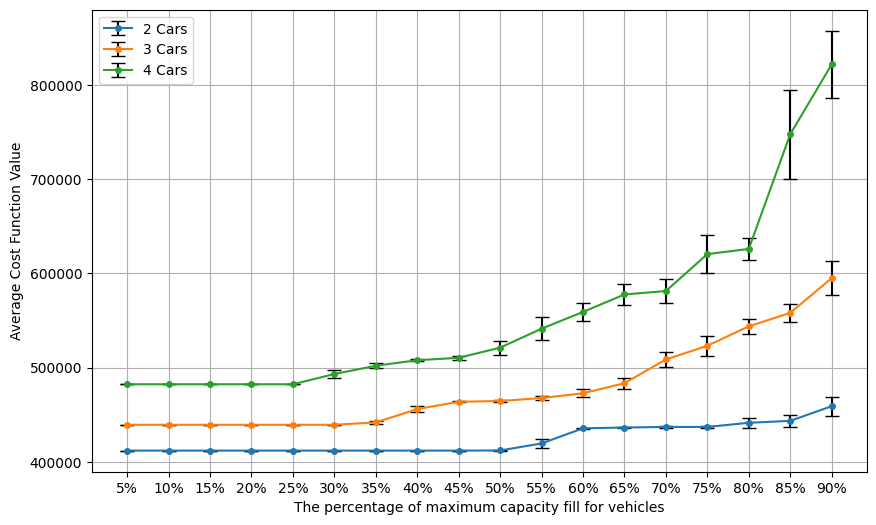

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

output_1 = [[value * 100 for value in lst] for lst in output_1]
output_2 = [[value * 100 for value in lst] for lst in output_2]
output_3 = [[value * 100 for value in lst] for lst in output_3]


data_2_cars = np.array(output_1)

data_3_cars = np.array(output_2)

data_4_cars = np.array(output_3)

mean_2_cars = np.mean(data_2_cars, axis=1)
sem_2_cars = sem(data_2_cars, axis=1)
sem_2_cars = np.std(data_2_cars, axis=1,ddof=1)

mean_3_cars = np.mean(data_3_cars, axis=1)
sem_3_cars = sem(data_3_cars, axis=1)
sem_3_cars = np.std(data_3_cars, axis=1,ddof=1)

mean_4_cars = np.mean(data_4_cars, axis=1)
sem_4_cars = sem(data_4_cars, axis=1)
sem_4_cars = np.std(data_4_cars, axis=1,ddof=1)


load_percentages = np.arange(5, 95, 5)

plt.figure(figsize=(10, 6))

plt.errorbar([f"{num}%" for num in load_percentages], mean_2_cars, yerr=sem_2_cars, label='2 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_3_cars, yerr=sem_3_cars, label='3 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_4_cars, yerr=sem_4_cars, label='4 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')

plt.xlabel('The percentage of maximum capacity fill for vehicles')
plt.ylabel('Average Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
nof_runs = 20
data_generation_percentege =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
output_4 = []

In [ ]:
def generate_demand_list(n, m, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if m >= n:
        raise ValueError("M must be less than N.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")

    random_values = np.random.rand(n - m - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    zeros_list = [0] * m

    result = list(rounded_values) + zeros_list

    random.shuffle(result)

    result = [-1] + result

    return result
def replace_zeros_with_sum(input_list, target_sum):
    zero_positions = [i for i, value in enumerate(input_list) if value == 0]
    num_zeros = len(zero_positions)

    result = input_list.copy()

    if num_zeros == 0:
        raise ValueError("There are no zeros to replace in the list.")

    random_values = np.random.rand(num_zeros)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    for i, pos in enumerate(zero_positions):
        result[pos] = rounded_values[i]

    return result


In [ ]:
for percent in data_generation_percentege:
    output_4.append([])
    for run_number in range(nof_runs):
        number_of_clients = 10
        number_of_vehicles = 2
        capacity_of_vehicle = 100
        demand_of_client = generate_list(number_of_clients + 1, percent * capacity_of_vehicle  *number_of_vehicles)
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()
        if pulp.LpStatus[problem.status] == "Optimal":
            print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

        output_4[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

Total Cost for 0.05% and run 0:, 3201.8
Total Cost for 0.05% and run 1:, 3201.8
Total Cost for 0.05% and run 2:, 3201.8
Total Cost for 0.05% and run 3:, 3201.8
Total Cost for 0.05% and run 4:, 3201.8
Total Cost for 0.05% and run 5:, 3201.8
Total Cost for 0.05% and run 6:, 3201.8
Total Cost for 0.05% and run 7:, 3201.8
Total Cost for 0.05% and run 8:, 3201.8
Total Cost for 0.05% and run 9:, 3201.8
Total Cost for 0.05% and run 10:, 3201.8
Total Cost for 0.05% and run 11:, 3201.8
Total Cost for 0.05% and run 12:, 3201.8
Total Cost for 0.05% and run 13:, 3201.8
Total Cost for 0.05% and run 14:, 3201.8
Total Cost for 0.05% and run 15:, 3201.8
Total Cost for 0.05% and run 16:, 3201.8
Total Cost for 0.05% and run 17:, 3201.8
Total Cost for 0.05% and run 18:, 3201.8
Total Cost for 0.05% and run 19:, 3201.8
Total Cost for 0.1% and run 0:, 3201.8
Total Cost for 0.1% and run 1:, 3201.8
Total Cost for 0.1% and run 2:, 3201.8
Total Cost for 0.1% and run 3:, 3201.8
Total Cost for 0.1% and run 4:, 32

In [ ]:
# print(output_4)
output_4 = [[3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.7999999999997, 3201.8, 3201.8, 3201.8, 3201.7999999999997, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8, 3201.8], [3321.8, 3493.7999999999997, 3476.7999999999997, 3321.7999999999997, 3321.7999999999997, 3321.7999999999997, 3321.8, 3201.7999999999997, 3201.7999999999997, 3201.8, 3201.7999999999997, 3321.8, 3201.7999999999997, 3201.7999999999997, 3321.7999999999997, 3201.7999999999997, 3493.8, 3201.7999999999997, 3201.7999999999997, 3201.7999999999997], [3476.8, 3201.7999999999997, 3493.7999999999997, 3321.7999999999997, 3696.7999999999997, 3476.8, 3321.7999999999997, 3476.7999999999997, 3493.7999999999997, 3576.7999999999997, 3321.7999999999997, 3476.7999999999997, 3321.7999999999997, 3476.8, 3575.7999999999997, 3575.7999999999997, 3476.8, 3493.7999999999997, 3493.7999999999997, 3476.7999999999997], [3576.8, 3575.7999999999997, 3493.8, 3575.8, 3476.7999999999997, 3696.8, 3476.7999999999997, 3736.7999999999997, 3744.7, 3476.8, 3476.7999999999997, 3476.7999999999997, 3493.7999999999997, 3696.7999999999997, 3736.8, 3696.8, 3736.7999999999997, 3744.7, 3736.7999999999997, 3493.7999999999997], [3493.7999999999997, 3736.8, 3696.8, 3696.8, 3493.8, 3744.7, 3476.8, 3476.7999999999997, 3576.8, 3493.8, 3493.7999999999997, 3476.7999999999997, 3476.7999999999997, 3476.7999999999997, 3696.7999999999997, 3696.8, 3576.7999999999997, 3476.7999999999997, 3576.8, 3736.7999999999997], [3744.7, 3744.7, 3744.7, 3736.8, 3744.7, 3736.7999999999997, 3744.7, 3576.8, 3576.8, 3696.8, 3744.7, 3576.8, 3736.8, 3744.7, 3696.7999999999997, 3736.8, 3744.7, 3736.8, 3576.7999999999997, 3744.7], [3744.7, 3744.7, 3744.7, 3576.8, 3736.7999999999997, 3915.7, 3744.7, 3852.7, 3744.7, 3744.7, 3744.7, 3736.8, 3745.7, 3576.7999999999997, 3745.7, 3576.7999999999997, 3744.7, 3745.7, 3744.7, 3745.7], [3745.7, 3745.7, 3576.7999999999997, 3736.7999999999997, 3852.7, 3493.8, 3745.7, 3744.7000000000003, 3745.7, 3745.7, 3915.7, 3745.7, 3745.7, 3744.7, 3744.7, 3852.7, 3744.7, 3744.7, 3576.7999999999997, 3744.7], [3744.7, 3852.7, 3744.7, 3852.7, 3744.7, 3915.7, 3745.7, 3915.7, 3874.7999999999997, 3745.7, 3744.7, 3852.7, 3576.8, 3806.7, 3745.7, 3744.7, 3745.7, 3744.7, 3852.7, 3915.7]]

In [ ]:
output_5 = []

In [ ]:
for percent in data_generation_percentege:
    output_5.append([])
    for run_number in range(nof_runs):
        number_of_clients = 10
        number_of_vehicles = 3
        capacity_of_vehicle = 100
        demand_of_client = generate_list(number_of_clients + 1, percent * capacity_of_vehicle  *number_of_vehicles)
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()
        if pulp.LpStatus[problem.status] == "Optimal":
          print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

        output_5[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

Total Cost for 0.05% and run 0:, 3475.7999999999997
Total Cost for 0.05% and run 1:, 3475.7999999999997
Total Cost for 0.05% and run 2:, 3475.7999999999997
Total Cost for 0.05% and run 3:, 3475.7999999999997
Total Cost for 0.05% and run 4:, 3475.7999999999997
Total Cost for 0.05% and run 5:, 3475.7999999999997
Total Cost for 0.05% and run 6:, 3475.7999999999997
Total Cost for 0.05% and run 7:, 3475.7999999999997
Total Cost for 0.05% and run 8:, 3475.7999999999997
Total Cost for 0.05% and run 9:, 3475.7999999999997
Total Cost for 0.05% and run 10:, 3475.7999999999997
Total Cost for 0.05% and run 11:, 3475.7999999999997
Total Cost for 0.05% and run 12:, 3475.7999999999997
Total Cost for 0.05% and run 13:, 3475.7999999999997
Total Cost for 0.05% and run 14:, 3475.7999999999997
Total Cost for 0.05% and run 15:, 3475.7999999999997
Total Cost for 0.05% and run 16:, 3475.7999999999997
Total Cost for 0.05% and run 17:, 3475.7999999999997
Total Cost for 0.05% and run 18:, 3475.7999999999997
Tot

In [ ]:
# print(output_5)
output_5 = [[3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997], [3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.8, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.8, 3475.7999999999997], [3475.7999999999997, 3729.7999999999997, 3475.7999999999997, 3475.8, 3475.7999999999997, 3475.8, 3475.8, 3475.7999999999997, 3730.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3475.7999999999997, 3910.8, 3475.8, 3475.8, 3475.8, 3475.8, 3475.8, 3729.7999999999997], [3978.7, 3910.8, 3729.7999999999997, 3729.7999999999997, 3730.7999999999997, 3730.7999999999997, 3869.7999999999997, 3869.7999999999997, 3730.8, 3730.8, 3869.7999999999997, 3475.8, 3730.7999999999997, 3729.7999999999997, 3475.7999999999997, 3730.7999999999997, 3475.7999999999997, 3910.7999999999997, 3475.7999999999997, 3475.8], [3978.7, 3910.8, 3729.7999999999997, 3475.8, 3910.8, 3730.8, 3730.8, 3910.7999999999997, 3978.7, 3869.7999999999997, 3978.7, 3910.7999999999997, 3910.8, 3869.7999999999997, 3978.7, 3869.7999999999997, 3869.7999999999997, 3910.8, 3979.7, 3869.7999999999997], [3910.7999999999997, 3978.7, 3978.7, 3978.7, 3978.7, 3869.8, 3730.7999999999997, 3910.7999999999997, 3979.7, 3978.7, 3730.7999999999997, 3910.7999999999997, 3730.7999999999997, 3978.7, 3910.7999999999997, 3910.7999999999997, 3910.8, 3978.7, 3730.8, 3910.7999999999997], [3978.7, 3978.7, 3979.7, 3979.7, 4026.7, 3730.8, 3979.7, 3730.7999999999997, 4087.7, 3910.7999999999997, 3979.7, 3910.7999999999997, 4025.7, 3978.7, 3910.7999999999997, 4026.7, 3979.7, 4019.7, 3910.8, 3978.7], [3979.7, 3979.7, 3910.8, 4025.7, 3978.7, 4019.7, 3910.7999999999997, 3979.7, 3979.7, 3978.7, 4019.7, 3979.7, 3979.7, 4025.7, 3979.7, 3978.7, 3910.7999999999997, 3978.7, 3979.7, 4025.7], [4026.7, 3910.7999999999997, 4088.7, 3979.7, 4212.7, 3979.7, 4026.7, 4152.7, 4126.7, 4111.8, 4019.7, 3978.7, 3978.7, 4400.7, 4019.7, 4221.7, 4096.799999999999, 4097.8, 4019.7, 3910.8], [4245.799999999999, 3869.7999999999997, 4026.7, 4189.7, 4318.7, 4097.799999999999, 4026.7, 4372.8, 4271.7, 4231.799999999999, 4126.7, 4026.7, 4162.8, 4245.799999999999, 4245.8, 4245.8, 4220.7, 4212.7, 4029.8, 4401.7], [4586.7, 4472.8, 4152.7, 4389.799999999999, 4317.7, 4427.7, 4245.8, 4353.7, 4471.8, 4097.799999999999, 4124.799999999999, 4464.7, 4254.7, 4301.7, 4301.7, 4231.8, 4389.8, 4269.7, 4557.7, 4515.7], [4145.8, 4614.7, 4415.7, 4254.7, 4353.7, 4245.8, 4414.7, 4699.7, 4414.7, 4463.7, 4245.799999999999, 4463.7, 5010.0, 4704.7, 4641.7, 4401.7, 4401.7, 4401.7, 4401.7, 4372.799999999999], [4496.7, 4651.7, 4899.7, 4587.7, 4640.7, 4381.7, 4642.7, 4633.8, 4401.7, 5232.1, 4400.7, 4245.799999999999, 4515.7, 4363.7, 4401.7, 4472.799999999999, 4353.7, 4590.799999999999, 4363.7, 4702.7]]

In [ ]:
output_6 =[]

In [ ]:
for percent in data_generation_percentege:
    output_6.append([])
    for run_number in range(nof_runs):
        number_of_clients = 10
        number_of_vehicles = 4
        capacity_of_vehicle = 100
        demand_of_client = generate_list(number_of_clients + 1, percent * capacity_of_vehicle  *number_of_vehicles)
        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
              for k in range(number_of_vehicles)]
              for j in range(number_of_clients + 1)]
            for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()
        if pulp.LpStatus[problem.status] == "Optimal":
          print(f"Total Cost for {percent}% and run {run_number}:, {pulp.value(problem.objective)}")

        output_6[data_generation_percentege.index(percent)].append(pulp.value(problem.objective))

Total Cost for 0.05% and run 0:, 4004.7999999999997
Total Cost for 0.05% and run 1:, 4004.7999999999997
Total Cost for 0.05% and run 2:, 4004.7999999999997
Total Cost for 0.05% and run 3:, 4004.7999999999997
Total Cost for 0.05% and run 4:, 4004.7999999999997
Total Cost for 0.05% and run 5:, 4004.7999999999997
Total Cost for 0.05% and run 6:, 4004.7999999999997
Total Cost for 0.05% and run 7:, 4004.7999999999997
Total Cost for 0.05% and run 8:, 4004.7999999999997
Total Cost for 0.05% and run 9:, 4004.7999999999997
Total Cost for 0.05% and run 10:, 4004.7999999999997
Total Cost for 0.05% and run 11:, 4004.7999999999997
Total Cost for 0.05% and run 12:, 4004.7999999999997
Total Cost for 0.05% and run 13:, 4004.7999999999997
Total Cost for 0.05% and run 14:, 4004.7999999999997
Total Cost for 0.05% and run 15:, 4004.7999999999997
Total Cost for 0.05% and run 16:, 4004.7999999999997
Total Cost for 0.05% and run 17:, 4004.7999999999997
Total Cost for 0.05% and run 18:, 4004.7999999999997
Tot

In [ ]:
# print(output_6)
output_6 = [[4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4144.8, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4144.8, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997], [4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4144.8, 4004.7999999999997, 4144.8, 4004.7999999999997, 4144.8, 4004.7999999999997, 4144.8, 4004.7999999999997, 4004.7999999999997, 4004.7999999999997, 4144.8, 4144.8, 4253.7, 4004.7999999999997, 4004.7999999999997], [4144.8, 4004.7999999999997, 4144.8, 4253.7, 4144.8, 4004.7999999999997, 4253.7, 4144.8, 4253.7, 4144.8, 4253.7, 4253.7, 4253.7, 4300.7, 4253.7, 4144.8, 4144.799999999999, 4144.8, 4144.8, 4253.7], [4300.7, 4299.7, 4253.7, 4253.7, 4144.8, 4253.7, 4300.7, 4362.7, 4253.7, 4144.8, 4144.8, 4371.799999999999, 4253.7, 4144.8, 4253.7, 4004.7999999999997, 4253.7, 4144.8, 4144.8, 4253.7], [4253.7, 4253.7, 4253.7, 4253.7, 4300.7, 4300.7, 4300.7, 4253.7, 4144.799999999999, 4253.7, 4253.7, 4300.7, 4371.8, 4363.7, 4253.7, 4253.7, 4300.7, 4253.7, 4253.7, 4004.7999999999997], [4371.8, 4253.7, 4462.799999999999, 4300.7, 4371.799999999999, 4300.7, 4253.7, 4555.7, 4426.7, 4371.8, 4253.7, 4316.7, 4371.8, 4253.7, 4426.7, 4253.7, 4385.8, 4300.7, 4253.7, 4253.7], [4617.7, 4385.8, 4558.8, 4648.7, 4253.7, 4486.7, 4385.8, 4300.7, 4486.7, 4385.8, 4253.7, 4486.7, 4371.799999999999, 4253.7, 4580.8, 4617.7, 4434.8, 4371.8, 4426.7, 4507.7], [4626.799999999999, 4649.7, 4253.7, 4648.7, 4771.799999999999, 4889.7, 4689.7, 4766.8, 4300.7, 4740.7, 4554.7, 4371.799999999999, 4626.8, 4654.8, 4398.799999999999, 4508.7, 4253.7, 4649.7, 4766.799999999999, 4508.7], [4508.7, 4554.7, 4829.8, 4875.7, 4689.7, 4867.8, 4618.7, 4689.7, 4399.799999999999, 4253.7, 4889.7, 4689.7, 4874.7, 4798.7, 4385.799999999999, 4829.799999999999, 4741.7, 4750.7, 4618.7, 4543.7], [4771.799999999999, 4889.7, 4940.7, 4555.7, 4555.7, 4649.7, 4875.7, 4752.7, 4766.799999999999, 4941.7, 4618.7, 4399.799999999999, 5125.8, 5452.0, 5534.1, 4937.7, 4689.7, 4889.7, 4648.7, 4922.7], [5167.7, 4795.7, 4889.7, 4983.7, 4999.7, 4757.7, 5010.7, 5167.7, 5257.7, 4922.7, 4757.7, 4689.7, 5168.7, 5249.7, 4876.7, 4694.7, 4741.7, 4941.7, 5212.7, 5370.7], [5105.799999999999, 4916.7, 4867.8, 6014.0, 5488.7, 5397.7, 5174.7, 5168.7, 5360.7, 5037.7, 5179.7, 5310.7, 5328.7, 4712.7, 5565.7, 4936.7, 4555.7, 5249.7, 4798.7, 5169.7], [5250.7, 5395.7, 5231.7, 4903.7, 5921.1, 5111.7, 5151.7, 4941.7, 5169.7, 5616.7, 5218.7, 5369.7, 5212.7, 5231.7, 5042.7, 6003.1, 5431.4, 4987.7, 5214.7, 4941.7]]

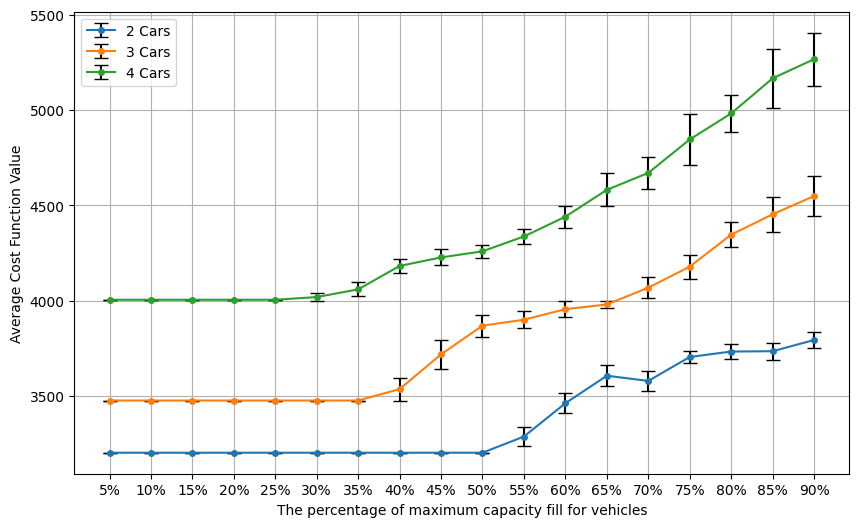

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

data_2_cars = np.array(output_4)
data_3_cars = np.array(output_5)
data_4_cars = np.array(output_6)

def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data, axis=1)
    std_dev = np.std(data, axis=1, ddof=1)
    n = data.shape[1]
    df = n - 1
    t_value = stats.t.ppf(1 - (1 - confidence) / 2, df)
    ci = t_value * std_dev / np.sqrt(n)
    return mean_val, ci

mean_2_cars, ci_2_cars = confidence_interval(data_2_cars)
mean_3_cars, ci_3_cars = confidence_interval(data_3_cars)
mean_4_cars, ci_4_cars = confidence_interval(data_4_cars)

load_percentages = np.arange(5, 95, 5)

plt.figure(figsize=(10, 6))

plt.errorbar([f"{num}%" for num in load_percentages], mean_2_cars, yerr=ci_2_cars, label='2 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_3_cars, yerr=ci_3_cars, label='3 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')
plt.errorbar([f"{num}%" for num in load_percentages], mean_4_cars, yerr=ci_4_cars, label='4 Cars', fmt='-o', markersize=4, capsize=5, ecolor='black')

plt.xlabel('The percentage of maximum capacity fill for vehicles')
plt.ylabel('Average Cost Function Value')
plt.legend()
plt.grid(True)
plt.show()
